In [28]:
#to install with pip tensorflow i had to change the registry value for longpaths.
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import   LabelEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

## Procesamiento y exploracion de datos

Leedmos el conjunto de datos que esta guardado en data

In [29]:
df=pd.read_csv('data/Results_TTM.csv',sep=";",header=0)
df=df.drop(columns=["Step status","Current trend","Torque rate min","Torque rate max","Torque rate trend","CVILOGIX","Identifier6","Identifier7","Identifier8","Identifier9","Identifier10","Second transducer torque deviation","Second transducer angle deviation","Result type","Pulse counter","Angle offset","AO torque rate"])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (45,46,63) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [30]:
print(df.describe)
df=df[['Result status','Result number','Time result','Pset ID','Step ID','Error Code', 'Torque min','Torque','Torque max','Angle min','Angle','Angle max','Pset name','VIN','Identifier1','Identifier2','Identifier3','Identifier4','Identifier5']]

<bound method NDFrame.describe of        Result status Tool status  Result number            Time result  \
0                 OK          OK         613029  2020-12-10 23:59:12.0   
1                 OK          OK         613028  2020-12-10 23:59:08.0   
2                 OK          OK         613027  2020-12-10 23:58:56.0   
3                 OK          OK         613026  2020-12-10 23:58:48.0   
4                 OK          OK         613025  2020-12-10 23:58:41.0   
...              ...         ...            ...                    ...   
399995            OK          OK         286841  2020-09-29 18:51:08.0   
399996            OK          OK         286840  2020-09-29 18:51:03.0   
399997            OK          OK         760759  2020-09-29 18:50:45.0   
399998            OK          OK         487287  2020-09-29 18:50:40.0   
399999            OK          OK         356116  2020-09-29 18:50:37.0   

        Pset ID  Step ID Error Code     Stop source  Torque min  Torque  ... 

Nos quedamos con las columnas que tienen valores interesante y eliminamos todas las columnas que contienen muchos nulos

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Result status  400000 non-null  object 
 1   Result number  400000 non-null  int64  
 2   Time result    400000 non-null  object 
 3   Pset ID        399901 non-null  float64
 4   Step ID        399901 non-null  float64
 5   Error Code     22688 non-null   object 
 6   Torque min     399901 non-null  float64
 7   Torque         400000 non-null  float64
 8   Torque max     399901 non-null  float64
 9   Angle min      399901 non-null  float64
 10  Angle          400000 non-null  float64
 11  Angle max      399901 non-null  float64
 12  Pset name      399901 non-null  object 
 13  VIN            172013 non-null  object 
 14  Identifier1    172013 non-null  object 
 15  Identifier2    170608 non-null  object 
 16  Identifier3    168406 non-null  object 
 17  Identifier4    13920 non-null

Tenombramos las columnas para eliminar los espacios.

In [32]:
df=df.rename(columns={"Result status":"Result_status","Result number":"Result_number","Pset ID":"Pset_ID","Step ID":"Step_ID","Torque min":"Torque_min","Torque max":"Torque_max","Angle min":"Angle_min","Angle max":"Angle_max","Pset name":"Pset_name",'Error code':'Error_code','Result_status':'Result_status','Time result':'Time_result'})


Vamos a mirar a ver cuales de los pares son NOK, filtramos la columna de resultado

In [33]:
df_nok=df[df['Result_status'].str.contains("NOK")]
df_nok.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22568 entries, 34 to 399969
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Result_status  22568 non-null  object 
 1   Result_number  22568 non-null  int64  
 2   Time_result    22568 non-null  object 
 3   Pset_ID        22568 non-null  float64
 4   Step_ID        22568 non-null  float64
 5   Error Code     22568 non-null  object 
 6   Torque_min     22568 non-null  float64
 7   Torque         22568 non-null  float64
 8   Torque_max     22568 non-null  float64
 9   Angle_min      22568 non-null  float64
 10  Angle          22568 non-null  float64
 11  Angle_max      22568 non-null  float64
 12  Pset_name      22568 non-null  object 
 13  VIN            9477 non-null   object 
 14  Identifier1    9477 non-null   object 
 15  Identifier2    9289 non-null   object 
 16  Identifier3    9301 non-null   object 
 17  Identifier4    1431 non-null   object 
 18  Iden

In [34]:
df_nok['Pset_name'].head()
df_nok[['Pset_name','Result_status']].groupby(by='Pset_name').count().sort_values(by=['Result_status'], ascending=False)

,Result_status
Pset_name,
Seat frame front_35Nm,1109
Armrests 28Nm,990
Slides 22Nm TX40 ISC,920
Cross angle back - Swivel_22Nm,885
Seat frame assy_35Nm_2x59-2_ISC,877
...,...
Backrest segment 22Nm ISC_A_BAU,1
Poka Yoke Check_6xxx,1
Torque_35Nm,1


Vemos que hay un resultado POKA YOKE, es un resultado NOK forzado que se hace para comprobar la herramientas. hay que quitarlos de la muestra.

In [35]:
df = df[~df["Pset_name"].str.contains("Poka",na=False)]

Cambiamos el tipo de la columna fecha

In [36]:
df.astype({'Time_result': 'datetime64[ns, US/Eastern]'}).dtypes

Result_status                        object
Result_number                         int64
Time_result      datetime64[ns, US/Eastern]
Pset_ID                             float64
Step_ID                             float64
Error Code                           object
Torque_min                          float64
Torque                              float64
Torque_max                          float64
Angle_min                           float64
Angle                               float64
Angle_max                           float64
Pset_name                            object
VIN                                  object
Identifier1                          object
Identifier2                          object
Identifier3                          object
Identifier4                          object
Identifier5                          object
dtype: object

creamos una columna nueva la columna de resultado que contiene los tesxtos "NOK" y "OK" en valores numericos.

In [37]:
df['Resultbin']=df['Result_status']=='OK'

In [38]:
df.head()


,Result_status,Result_number,Time_result,Pset_ID,Step_ID,Error Code,Torque_min,Torque,Torque_max,Angle_min,Angle,Angle_max,Pset_name,VIN,Identifier1,Identifier2,Identifier3,Identifier4,Identifier5,Resultbin
0,OK,613029,2020-12-10 23:59:12.0,10.0,1.0,NaN,18.0,20.126,22.0,3.0,40.213,100.0,Fixation screw_(60895R01)_20Nm_1x64-5_IF,NaN,NaN,NaN,NaN,NaN,NaN,True
1,OK,613028,2020-12-10 23:59:08.0,9.0,1.0,NaN,18.0,20.090,22.0,5.0,40.369,100.0,Fixation screw_(318327B01)_20Nm_1x64-4_I,NaN,NaN,NaN,NaN,NaN,NaN,True
2,OK,613027,2020-12-10 23:58:56.0,3.0,1.0,NaN,20.0,22.219,24.0,5.0,40.389,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True
3,OK,613026,2020-12-10 23:58:48.0,3.0,1.0,NaN,20.0,22.138,24.0,5.0,33.650,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True
4,OK,613025,2020-12-10 23:58:41.0,3.0,1.0,NaN,20.0,22.073,24.0,5.0,43.830,110.0,Sliders 22Nm_4x65-4_ISC,NaN,NaN,NaN,NaN,NaN,NaN,True


Aun tenemos columnas que no van a aportar nada a nuestro modelo.

In [39]:
dfX=df.drop(columns={'Result_status','Result_number','Time_result','Pset_ID','Identifier4','Identifier5','Identifier2','Error Code','Torque','Angle'})

con df.info() vamos a ver cuantas columnas contienen resultados nulos y vamos a hacer que toda la muestra tenga columnas con datos que podamos utilizar.
Con esta accion podemos hacer que nuestro modelo posterior no sea tan bueno prediciendo los resultados de las columnas que tienen nulls.

In [40]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398943 entries, 0 to 399999
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Step_ID      398844 non-null  float64
 1   Torque_min   398844 non-null  float64
 2   Torque_max   398844 non-null  float64
 3   Angle_min    398844 non-null  float64
 4   Angle_max    398844 non-null  float64
 5   Pset_name    398844 non-null  object 
 6   VIN          172013 non-null  object 
 7   Identifier1  172013 non-null  object 
 8   Identifier3  168406 non-null  object 
 9   Resultbin    398943 non-null  bool   
dtypes: bool(1), float64(5), object(4)
memory usage: 30.8+ MB


Vamos a echar un vistazo a los valores que vamos a quitar. porque se va a reducir mucho la muestra.

In [41]:

df_NANs=dfX[['Pset_name','Identifier1','Identifier3','Resultbin']]
df_NANs.loc[df_NANs['Identifier1'].isnull(),'value_is_NaN'] = 'Yes'
df_NANs.loc[df_NANs['Identifier1'].notnull(), 'value_is_NaN'] = 'No'
df_NANs = df_NANs[df_NANs["value_is_NaN"].str.contains("Yes",na=False)]
df_NANs[['Pset_name','Resultbin']].groupby(by='Pset_name').count().sort_values(by='Resultbin',ascending=False)



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Resultbin
Pset_name,
Sliders 22Nm_4x65-4_ISC,19342
Backrest_40Nm,10887
Seat frame assy_35Nm_2x59-2_ISC,10709
Bearing inclination cap_22Nm_2x59-1_ISC,10022
Inner carrier_22Nm_2x59-3_ISC,9927
...,...
Cushion slides_WOOD_10Nm+-2,80
Embocar Profiles 30Nm ISC,77
Slides 22Nm TX40 ISC,6


Estamos perdiendo valores OK y NOK de las líneas NTS1 y NTS2 que no guardan valueIdentifiers. Es decir que el analisis se va a focalizar en las líneas:
1. ALter BAU
2. Alter BUS
3. Tapizado NTS1
4. Tapizado NTS2
5. NTS1 BAU
Vamos a proceder a eliminar los resultados nulos del Df

In [42]:
dfX=dfX.dropna()
dfX = dfX[pd.to_numeric(dfX['Identifier3'],errors='coerce').notna()]
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168002 entries, 10 to 399996
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Step_ID      168002 non-null  float64
 1   Torque_min   168002 non-null  float64
 2   Torque_max   168002 non-null  float64
 3   Angle_min    168002 non-null  float64
 4   Angle_max    168002 non-null  float64
 5   Pset_name    168002 non-null  object 
 6   VIN          168002 non-null  object 
 7   Identifier1  168002 non-null  object 
 8   Identifier3  168002 non-null  object 
 9   Resultbin    168002 non-null  bool   
dtypes: bool(1), float64(5), object(4)
memory usage: 13.0+ MB


Observamos ahora que tenemos 168.002 registros no nulos con los que podemos elaborar un modelo. vamos a ver el porcentaje de aprietes NOK totales.  

In [43]:
dfX[['Resultbin','Step_ID']].groupby(by='Resultbin').count()

,Step_ID
Resultbin,
False,9236
True,158766


In [44]:
OKS = len(df[df["Result_status"].str.contains("OK",na=False)])
NOKS=len(df[df["Result_status"].str.contains("NOK",na=False)])
NOKS/OKS

0.05391998355654818

Tenemos un 5% de pares malos en este conjunto de datos.

vamos a quitar algunos ok para que los modelos aprendan mejor:

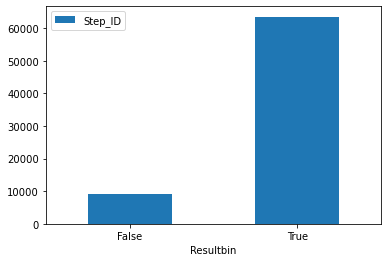

In [45]:
dfX = dfX.drop(dfX[dfX['Resultbin'] == True].sample(frac=.6, random_state=101).index)
#Quito el 40 % de los resultados OK  de DFX
dfX_plot=dfX[['Resultbin','Step_ID']].groupby(by='Resultbin').count()
ax = dfX_plot.plot.bar(y='Step_ID',rot=0)

In [46]:
OKS = len(df[df["Result_status"].str.contains("OK",na=False)])
NOKS=len(df[df["Result_status"].str.contains("NOK",na=False)])
NOKS/OKS



0.05391998355654818

In [47]:
enc=LabelEncoder()
dfX=df[['Torque_min','Torque_max','Angle_min','Angle_max','Pset_name',	'Identifier1','Identifier3','Resultbin']].dropna()
dfX = dfX.drop(dfX[dfX['Resultbin'] == True].sample(frac=.4, random_state=101).index)
#Quito el 40 % de los resultados OK  de DFX

dfX['Identifier3'] = df['Identifier3'].astype('string',copy=False)
dfX['Pset_name_cat'] = enc.fit_transform(dfX['Pset_name'])
dfX['Modelo'] = enc.fit_transform(dfX['Identifier1'])
dfX[['Identifier3','Resultbin']].groupby(by="Identifier3").count()
dfX[dfX['Identifier3'].apply(lambda x: x.isnumeric())]
dfX['Trabajador'] = enc.fit_transform(dfX['Identifier3'])


In [48]:
dfX[['Identifier3','Resultbin']].groupby(by="Identifier3").count()

,Resultbin
Identifier3,
1234.0,2
1412.0,45
1505,12
1505.0,2206
2072.0,6
...,...
6000,134
6000.0,636
9385.0,2


In [49]:
dfX[['Resultbin','Pset_name_cat']].groupby(by='Resultbin').count()

,Pset_name_cat
Resultbin,
False,9236
True,95271


In [50]:
dfX.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104507 entries, 17 to 399996
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Torque_min     104507 non-null  float64
 1   Torque_max     104507 non-null  float64
 2   Angle_min      104507 non-null  float64
 3   Angle_max      104507 non-null  float64
 4   Pset_name      104507 non-null  object 
 5   Identifier1    104507 non-null  object 
 6   Identifier3    104507 non-null  string 
 7   Resultbin      104507 non-null  bool   
 8   Pset_name_cat  104507 non-null  int32  
 9   Modelo         104507 non-null  int32  
 10  Trabajador     104507 non-null  int32  
dtypes: bool(1), float64(4), int32(3), object(2), string(1)
memory usage: 7.7+ MB


Ok, ahora vamos a dejar el df solo con las columnas que nos interesan y empezaremos a preparar nuestro modelo.

In [51]:
dfX["Resultbin"] = dfX["Resultbin"].astype(int)
y=np.array(dfX["Resultbin"])
dfX=dfX.drop(columns={'Resultbin','Pset_name','Identifier1','Identifier3'})
X=dfX.values
print(y, X)



[1 1 1 ... 1 1 1] [[  7.  13.   0. ...  19. 115.  45.]
 [ 20.  22.   0. ...  73. 306.  73.]
 [ 20.  24.   0. ...  21. 306.  73.]
 ...
 [ 30.  40.   0. ...  27.  41.  89.]
 [ 20.  24.   0. ...  21.  41.  42.]
 [ 20.  24.   0. ...  21.  41.  42.]]


In [52]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, BinaryCrossentropy
from sklearn.utils import shuffle
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs available:", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

label=np.array(y)
sample=np.array(X)

print(label.shape,sample.shape)



Num GPUs available: 1
(104507,) (104507, 7)


In [53]:
label,sample =shuffle(label,sample)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_samples= scaler.fit_transform(sample) #fit transform does not accept 1D data so we reshape the scaled train samples to be 2D


In [54]:
import seaborn as sns
# sns.pairplot (dfX)

In [55]:
print(y, X)
print(y.shape,X.shape)

[1 1 1 ... 1 1 1] [[  7.  13.   0. ...  19. 115.  45.]
 [ 20.  22.   0. ...  73. 306.  73.]
 [ 20.  24.   0. ...  21. 306.  73.]
 ...
 [ 30.  40.   0. ...  27.  41.  89.]
 [ 20.  24.   0. ...  21.  41.  42.]
 [ 20.  24.   0. ...  21.  41.  42.]]
(104507,) (104507, 7)


In [56]:
print(label,scaled_samples)
print(label.shape,scaled_samples.shape)

[1 1 1 ... 1 1 1] [[0.5        0.475      0.         ... 0.15789474 0.23870968 0.79824561]
 [0.5        0.475      0.         ... 0.72932331 0.32580645 0.57894737]
 [0.5        0.475      0.         ... 0.80451128 0.27096774 0.39473684]
 ...
 [0.5        0.475      0.         ... 0.0075188  0.46774194 0.36842105]
 [0.5        0.475      0.         ... 0.80451128 0.28709677 0.37719298]
 [0.5        0.425      0.         ... 0.30827068 0.26451613 0.85964912]]
(104507,) (104507, 7)


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_samples, label, test_size=0.33, random_state=42)


In [58]:
print(X_test.shape, X_train.shape)
print(y_test.shape,y_train.shape)

(34488, 7) (70019, 7)
(34488,) (70019,)


In [59]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

NameError: name 'keras' is not defined

## Comprender métricas útiles

Tenga en cuenta que hay algunas métricas definidas anteriormente que pueden ser calculadas por el modelo y que serán útiles al evaluar el desempeño.

* Los falsos negativos y falsos positivos son muestras que fueron clasificadas incorrectamente.

* Verdaderos negativos y positivos verdaderos son muestras que fueron clasificados correctamente.

* La precisión es el porcentaje de ejemplos correctamente clasificada.

* La precisión es el porcentaje de positivos predichos que se clasifican correctamente.

* Recall es el porcentaje de positivos reales que fueron clasificados correctamente.

* AUC se refiere al área bajo la curva de una curva característica de funcionamiento del receptor (ROC-AUC). Esta métrica es igual a la probabilidad de que un clasificador clasifique una muestra positiva aleatoria por encima de una muestra negativa aleatoria.

* AUPRC se refiere al área bajo la curva de la curva de precisión de recordar. Esta métrica calcula pares de recuperación de precisión para diferentes umbrales de probabilidad.

In [ ]:
def make_model(metrics=METRICS,output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        Dense(units=16,input_shape=[len(dfX.keys())],activation='relu'),
        Dense(units=32,activation='relu'),
        Dense(units=32,activation='relu'),
        Dropout(0.5),
        Dense(units=2,activation='sigmoid',bias_initializer=output_bias)  # dos clases, par ok par nok.
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    # voy a cambiar el optimizer a ver si mejora 
    # from tensorflow.keras.optimizers import SGD
    # from tensorflow.keras.metrics import categorical_crossentropy
    # opt = SGD(learning_rate=0.01)
    # model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics= ['accuracy'])
    
    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

 # Tune model with keras tuner
 

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)

  model.add(tf.keras.layers.Dense(units=16,input_shape=[len(dfX.keys())],activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu')) #added one layer more
  model.add(tf.keras.layers.Dense(units=2,activation='sigmoid'))  #changed to sigmoid => is equivalent to softmax for two outputs

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

In [ ]:
model=make_model()
model.summary()

In [ ]:
results = model.evaluate(X_train, y_train, batch_size=10, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

## Train the model

In [ ]:
model.fit(x=X_train,y=y_train, validation_split=0.1,batch_size=10,epochs=10,shuffle=True, verbose=2)

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs

# model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

Esto me va a decir cual es el best epoch, reentreno el modelo definiendo el best epoch.

In [ ]:
# Retrain the model


# hypermodel = tuner.hypermodel.build(best_hps)
# hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)

## Predictions and confusion matrix

Calculate predictions

In [ ]:
precictions=model.predict(x=X_test.tolist(),batch_size=10,verbose=0)
print(precictions)

Plot confusion matrix

In [ ]:
rounded_predictions=np.argmax(precictions,axis=-1)

In [ ]:

import numpy as np
import  itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:

cm = confusion_matrix(y_true=y_test,y_pred=rounded_predictions)
cm_plot_labels=['no OK','OK']
plot_confusion_matrix (cm,cm_plot_labels,title='Confusion matrix')
plt.show()

Me pasa lo mismo que con el modelo de regresion lineal => hay que tratar los datos para incrementar el numero de resultados NOK porcentualmente sobre el total de datos.

### confusion matrix logistic regresion in TTM_Pamplona

[   12,  2308]


[    0, 39686]
con todo el dataframe  Neural Network % nok predicted good = 0,005
tras reducir el número de pares Ok un 40% me sale la siguiente cm: Neural Network % nok predicted good 0.027

[   80  2905]


[    0 52462]

quitando el angulo minimo. Neural Network % nok predicted good: 0.017

[   53  3039]


[    0 52355]

vamos a volver a añadir  los pares ok a ver que hace but still i am too far

con el 60% de los pares ok quitados: Neural Network % nok predicted NOK: 0.016

[   48  3026]


[    0 52373]

vuelvo a poner el angulo mímimo.


In [ ]:
porcentaje_pares_LR=12/(12+2308)
porcentaje_pares_NN=cm[0,0]/(cm[0,0]+cm[0,1])

print("Logistic regresion % nok predicted as NOK: "+str(round(porcentaje_pares_LR,3)))
print("Neural Network % nok predicted NOK: "+str(round(porcentaje_pares_NN,3)))

1. **Use weight regularization.** It tries to keep weights low which very often leads to better generalization. Experiment with different regularization coefficients. Try 0.1, 0.01, 0.001 and see what impact they have on accuracy.


2. **Corrupt your input** (e.g., randomly substitute some pixels with black or white). This way you remove information from your input and 'force' the network to pick up on important general features. Experiment with noising coefficients which determines how much of your input should be corrupted. Research shows that anything in the range of 15% - 45% works well.


3. **Expand your training set.** Since you're dealing with images you can expand your set by rotating / scaling etc. your existing images (as suggested). You could also experiment with pre-processing your images (e.g., mapping them to black and white, grayscale etc. but the effectiveness of this technique will depend on your exact images and classes)


4. **Pre-train your layers with denoising critera.** Here you pre-train each layer of your network individually before fine tuning the entire network. Pre-training 'forces' layers to pick up on important general features that are useful for reconstructing the input signal. Look into auto-encoders for example (they've been applied to image classification in the past).


5. **Experiment with network architecture.** Your network might not have sufficient learning capacity. Experiment with different neuron types, number of layers, and number of hidden neurons. Make sure to try compressing architectures (less neurons than inputs) and sparse architectures (more neurons than inputs).

1. reducir aun mas los ok => cuanto mas?

2. meter mas layers => done

3. cambiar de softmax a sigmoid => done

4. tune hiper parameters => done

5. Ampliar el dataset con más NOK results


## Random forest clasifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

predict:

In [ ]:
prediction_rf = rf.predict(X_train)

print( np.unique( prediction_rf ) )

print( accuracy_score(y_train, prediction_rf) )

 

prob_y_4 = rf.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]
print( roc_auc_score(y_train, prob_y_4) )


parece que estamos en las mismas...

In [ ]:
prediction_rf_test=rf.predict(X_test)
cm_rf = confusion_matrix(y_true=y_test,y_pred=prediction_rf_test)
cm_plot_labels_rf=['no OK','OK']
plot_confusion_matrix (cm_rf,cm_plot_labels_rf,title='Confusion matrix Random forest clasifier')
plt.show()

In [ ]:
print(prediction_rf)

In [ ]:
estimator = rf.estimators_[5]
feature_names=[]
for col in dfX.columns:
    feature_names.append(col)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = feature_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'],shell=False)

# Find the image on src